In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
torch.backends.cudnn.benchmark=True
PIN=device.type=="cuda"

In [4]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(64*7*7, 128)
        self.fc2   = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [5]:
transform=transforms.Compose([transforms.ToTensor()])
train_dts=datasets.MNIST(root="../Data",train=True,download=True,transform=transform)
test_dts=datasets.MNIST(root="../Data",train=False,download=True,transform=transform)
train_load=DataLoader(train_dts,batch_size=256,shuffle=True,num_workers=4,pin_memory=PIN,persistent_workers=True)
test_load=DataLoader(test_dts,batch_size=512,shuffle=False,num_workers=4,pin_memory=PIN,persistent_workers=True)


In [6]:
from torch.amp import autocast, GradScaler

model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)  
scaler = GradScaler("cuda")
print(model)
print(criterion)
print(optimizer)
print(scaler)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
CrossEntropyLoss()
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)


In [7]:
import time
from torch.amp import autocast, GradScaler

scaler = GradScaler("cuda")  # PyTorch 2.1+ style

epochs = 10
for epoch in range(1, epochs + 1):
  
    model.train()
    epoch_loss = 0.0
    correct = 0
    n = 0
    t0 = time.perf_counter()

    for x_batch, y_batch in train_load:
        x_batch = x_batch.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True).long()

        optimizer.zero_grad(set_to_none=True)

        
        with autocast("cuda"):
            logits = model(x_batch)
            loss = criterion(logits, y_batch)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        
        bs = x_batch.size(0)
        epoch_loss += loss.item() * bs
        correct += (logits.argmax(1) == y_batch).sum().item()
        n += bs

    train_loss = epoch_loss / n
    train_acc = correct / n

  
    model.eval()
    test_loss = 0.0
    correct_t = 0
    n_t = 0
    with torch.no_grad(), autocast("cuda"):
        for x_batch, y_batch in test_load:
            x_batch = x_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True).long()

            logits = model(x_batch)
            loss = criterion(logits, y_batch)

            bs = x_batch.size(0)
            test_loss += loss.item() * bs
            correct_t += (logits.argmax(1) == y_batch).sum().item()
            n_t += bs

    test_loss /= n_t
    test_acc = correct_t / n_t

    dt = time.perf_counter() - t0
    print(f"Epoch {epoch:02d} | {dt:.1f}s | "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"test  loss {test_loss:.4f} acc {test_acc:.4f}")


Epoch 01 | 8.3s | train loss 0.3327 acc 0.9022 | test  loss 0.0898 acc 0.9722
Epoch 02 | 1.5s | train loss 0.0729 acc 0.9779 | test  loss 0.0441 acc 0.9863
Epoch 03 | 1.5s | train loss 0.0479 acc 0.9855 | test  loss 0.0404 acc 0.9856
Epoch 04 | 1.4s | train loss 0.0369 acc 0.9887 | test  loss 0.0350 acc 0.9883
Epoch 05 | 1.6s | train loss 0.0313 acc 0.9904 | test  loss 0.0339 acc 0.9878
Epoch 06 | 1.5s | train loss 0.0256 acc 0.9924 | test  loss 0.0295 acc 0.9900
Epoch 07 | 1.5s | train loss 0.0202 acc 0.9937 | test  loss 0.0319 acc 0.9888
Epoch 08 | 1.5s | train loss 0.0180 acc 0.9943 | test  loss 0.0316 acc 0.9892
Epoch 09 | 2.0s | train loss 0.0143 acc 0.9958 | test  loss 0.0309 acc 0.9898
Epoch 10 | 2.1s | train loss 0.0125 acc 0.9959 | test  loss 0.0308 acc 0.9888


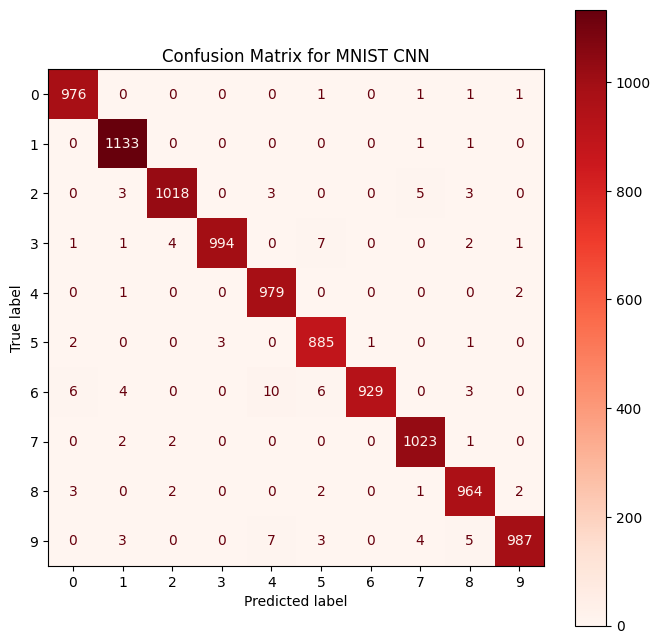

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_load:
        xb = xb.to(device)
        yb = yb.to(device)

        logits = model(xb)
        preds = logits.argmax(1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(yb.cpu().numpy())


y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))


fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Reds", colorbar=True)
plt.title("Confusion Matrix for MNIST CNN")
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt



import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def grad_cam(model, image, target_class, target_layer):
    model.eval()
    
   
    activations = {}
    gradients = {}
    
    def forward_hook(module, inp, out):
        activations['value'] = out.detach()
    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()
    
    
    handle_f = target_layer.register_forward_hook(forward_hook)
    handle_b = target_layer.register_full_backward_hook(backward_hook)
  
    image = image.unsqueeze(0)  
    image = image.to(next(model.parameters()).device)
    output = model(image)
    pred_class = output.argmax(1).item()
    
   
    model.zero_grad()
    loss = output[0, target_class]
    loss.backward()
    
   
    act = activations['value']
    grad=gradients["value"]        
    weights = grad.mean(dim=(2,3), keepdim=True)  
    cam = (weights * act).sum(1, keepdim=True)    
    cam = F.relu(cam)
    
   
    
    cam = cam.squeeze().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)
    
    
    handle_f.remove()
    handle_b.remove()
    
    return cam, pred_class

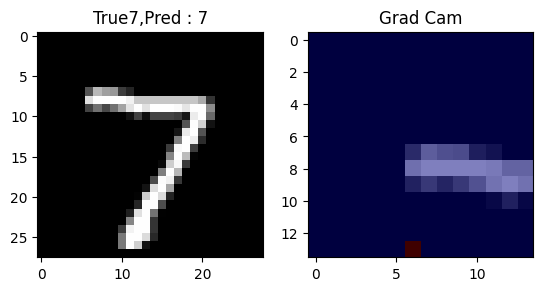

In [10]:
img,label=test_dts[0]
cam,pred=grad_cam(model,img,target_class=label,target_layer=model.conv2)

plt.subplot(1,2,1)
plt.imshow(img.squeeze(),cmap="gray")
plt.title(f"True{label},Pred : {pred}")


plt.subplot(1,2,2)
plt.imshow(img.squeeze(),cmap="gray")
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.title("Grad Cam")
plt.show()